# Project 1: shared memory programming

**Due Saturday, February 20 (end of the day)**

**collaboration / works consulted statement:**
Partners: Wesley Ford, Michael Garmarnik

## Logistics

In this project you will parallelize a simulation of interacting particles.

You can work in teams of up to three students.

You may discuss the assignment with other students, and you may consult outside sources for ideas to improve the performance of your code, to help you troubleshoot bugs, etc.

All code and written components **must** be your own writing.

**Presentation component:** On **Thursday, February 18**, your group will meet with other groups to discuss the relative merits of the GPU vs the host CPUs to solve this problem.  For full credit for that activity, you group must come prepared with measurements of how well your code performs at that point.  (You may make changes to your code based on what you learned that day).

## Running this assignment on `coc-ice` at PACE

1. Once you have downloaded this notebook from canvas, upload it to your directory on `coc-ice` using a command line tool like `scp` or a GUI like [filezilla](https://filezilla-project.org/).

2. On `coc-ice` you will probably want to place this notebook in its own directory, like `cx4220-proj1` or similar.  Jupyter notebooks automatically save checkpoints, but you may want to version control this assignment with [git](https://git-scm.com/).

3. I have set up a way for you to use the julia kernel in jupyter notebooks on `coc-ice`.  Run the following two commands from the command line (you may even want to add them to your `~/.bash_profile` so they run each time you log in.)
    
```bash
module use /storge/home/hcocice1/tisaac3/opt/pace-ice/modulefiles
module load cx4220
```

4. From your directory for this project, run this command to ask for a notebook to run on a compute node of `coc-ice`:
    
```bash
pace-jupyter-notebook -q coc-ice-gpu -l nodes=1:ppn=24:gpus=1,walltime=02:00:00
```

5. Follow the instructions on the screen to open your jupyter notebook session in a browser window.

6. Once you have opened this notebook on the compute node, you need to ask julia to use as much thread-level parallelism as possible.  Do that by switching the kernel to `Julia 24 Threads` under "Kernel > Change kernel" at the top of the page.

## Getting started

This cell will install julia packages that you will need to work on this assignment.  To save time, only evaluate this cell once.

In [2]:
import Pkg
Pkg.add("Plots")
Pkg.add("SIMD")
Pkg.add("BenchmarkTools")
Pkg.add("CUDA")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [====================================

Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


The first tme you evaluate this statements, it will compile the packages, which may take some time.

In [1]:
import SIMD: Vec, VecRange # You may want to use these to improve the performance
                           # of your implementations
using Plots
using LinearAlgebra
using CUDA
import BenchmarkTools.@belapsed

## Interacting particles

I have created a make-believe 4-D particle.  If particle $A$ has position $x$ and velocity $v$, and particle $B$ has position $y$ and velocity $w$, then the force of particle $B$ on particle $A$ is described by the vector $a$ computed by the function `acceleration_add`:

In [2]:
@inline function acceleration_add(x::NTuple{4,T},
                          y::NTuple{4,T},
                          v::NTuple{4,T},
                          w::NTuple{4,T},
                          a::NTuple{4,T})::NTuple{4,T} where{T}
    @fastmath d = (x[1]-y[1],x[2]-y[2],x[3]-y[3],x[4]-y[4])
    @fastmath e = (v[1]-w[1],v[2]-w[2],v[3]-w[3],v[4]-w[4])
    @fastmath r2 = (d[1]*d[1]+d[2]*d[2]+d[3]*d[3]+d[4]*d[4]) + T(0.01)
    @fastmath a = (a[1]+d[1],a[2]+d[2],a[3]+d[3],a[4]+d[4])
    scale = T(0.05) / r2
    @fastmath a = (a[1]+d[1],a[2]+d[2],a[3]+d[3],a[4]+d[4])
    @fastmath a = (a[1]-scale*e[1],a[2]-scale*e[2],a[3]-scale*e[3],a[4]-scale*e[4])
    scale = T(0.1)
    @fastmath a = (a[1]+scale*e[1],a[2]+scale*e[2],a[3]+scale*e[3],a[4]+scale*e[4])
    return a
end

acceleration_add (generic function with 1 method)

If we want to know all the forces acting on a vector of particles, I have to sum up the force of each particle on each for $n^2$ interactions, which is called an $n$-body simulation, as in the function `acceleration!` which stores the forces acting on the particles in the $n\times 4$ matrix `a`.

In [3]:
function acceleration!(x::AbstractMatrix{T}, v::AbstractMatrix{T}, a::AbstractMatrix{T})::Nothing where{T}
    n = size(x,1)
    @assert n == size(v,1)
    @assert 4 == size(x,2)
    @assert 4 == size(v,2)
    
    scale = one(T) / n
    for i = 1:n
        @inbounds xi = (x[i,1], x[i,2], x[i,3], x[i,4])
        @inbounds vi = (v[i,1], v[i,2], v[i,3], v[i,4])
        ai = (zero(T), zero(T), zero(T), zero(T))
        for j = 1:n
            @inbounds xj = (x[j,1], x[j,2], x[j,3], x[j,4])
            @inbounds vj = (v[j,1], v[j,2], v[j,3], v[j,4])
            ai = acceleration_add(xi, xj, vi, vj, ai)
        end
        @inbounds a[i,1:4] .= scale .* ai .+ 0.1 .* xi
    end
    return nothing     
end

acceleration! (generic function with 1 method)

Here is a useful 3D plotting routine.

In [4]:
using Plots

function plot_particles(x)
    plot(x[:,1], x[:,2], x[:,3],
         size=(600,500),
         seriestype=:scatter,
         marker=3, marker_z=x[:,1], clims=(-1,1), c=:PiYG,
         xlim=(-1,1), ylim=(-1, 1), zlim=(-1, 1),
         legend=false, colorbar=false)
end

plot_particles (generic function with 1 method)

`simulate!` takes the positions `x` and velocities `v` at an initial time and simulate their motion for a number of `timesteps` by applying the acceleration to change the velocities and then the velocities to change the positions.

In [5]:
function simulate!(x::Matrix{T}, v::Matrix{T}, timesteps; animate_interval=1, anim=nothing) where{T}
    a = similar(x)
    if anim != nothing
        plot_particles(x)
        frame(anim)
    end
    dt = 0.05
    for t = 1:timesteps
        acceleration!(x, v, a)
        v .-= dt .* a
        x .+= dt .* v
        if anim != nothing && t % animate_interval == 0
            plot_particles(x)
            frame(anim)
        end
    end
    if anim != nothing
        return anim
    else
        return nothing
    end
end

simulate! (generic function with 1 method)

Here is an example:

In [6]:
n = 100
X = rand(n,4)
V = rand(n,4)

@views for i = 1:n
    x = X[i,:]
    xnorm = norm(x)
    X[i,:] = x ./ xnorm
    v = V[i,:]
    vnorm = norm(v)
    V[i,:] = v ./ vnorm
    V[i,1] *= -1
    V[i,3] *= -1
end

anim = simulate!(X, V, 100; animate_interval=1, anim=Animation())
gif(anim,"particles_example.gif");

┌ Info: Saved animation to 
│   fn = /storage/home/hcocice1/wford32/cx4220_project1/wesley/particles_example.gif
└ @ Plots /storage/home/hcocice1/wford32/.julia/packages/Plots/6EMd6/src/animation.jl:104


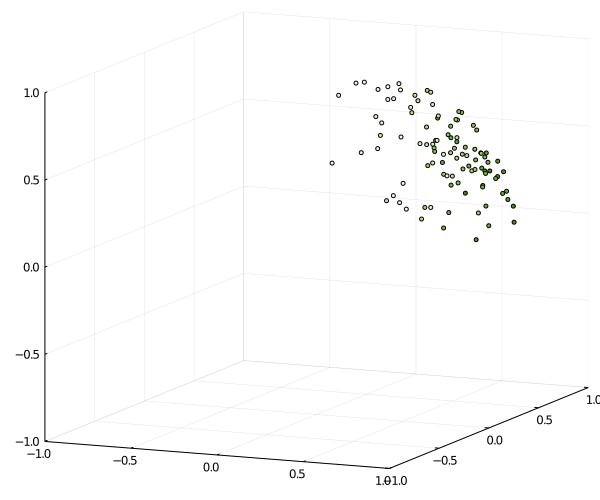

In [7]:
Ns = [n for n = 10:10:100]
Ts = []

for n in Ns    
    X = rand(n,4)
    V = rand(n,4)
    t = @belapsed simulate!($X, $V, 10)
    push!(Ts, t / 10.)
end

As you can see, the $n^2$ interactions lead to quadratic complexity in the work to simulate one timestep:

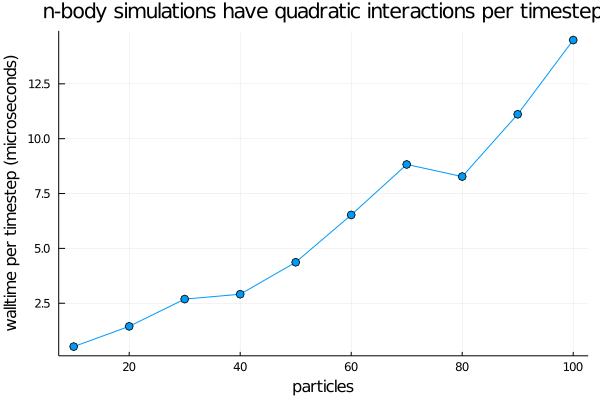

In [8]:
plot(Ns,
     Ts / 1.e-6,
     title="n-body simulations have quadratic interactions per timestep",
     marker=:o,
     legend=false,
     xlabel="particles",
     ylabel="walltime per timestep (microseconds)")

### Part 1: write shared memory parellelism (5 points correctness, 5 points performance)

Modify `acceleration!` and `simulate!` to use _shared memory parallelism_ on the compute node cpus.  julia supports _task-based_ parallelism with `Threads.@spawn` and `Threads.wait` and `Threads.fetch`, and _loop-based_ parallelism with `Threads.@threads` to modify for-loops.  Your functions should use the requested number of threads `nthreads`.

Suggestions:

- Loop-based parallelism is the natural approach to take for parallelizing these two functions, but
```julia
Threads.@threads for i = 1:n
    ...
end
```
will always use all available threads, which is not what we want.  Consider using the following construct,
```julia
Threads.@threads for threadid = 1:nthreads
    ...
end
```
which will allow you easily create a parallel region with `nthreads`.  The only problem is, you must now determine how to divide of the loop iterations for yourself.

- You can parallelize broadcasts like `A .= B .+ C` by turning them into for-loops.

- You are allowed to optimize the functions beyond introducing thread-level parallelism.  By my estmates, using instruction level parallelism / vectorization can give an additional ~10% speed up.

In [6]:
#Add any helper functions you need here 
# your code here

function acceleration_shared_memory!(x::Matrix{Float64}, v::Matrix{Float64},
                                     a::Matrix{Float64};
                                     nthreads=Threads.nthreads())
    n = size(x,1)
    @assert n == size(v,1)
    @assert 4 == size(x,2)
    @assert 4 == size(v,2)
    scale = 1/n
    Threads.@threads for threadid = 1:nthreads
        @fastmath threadmin = div(n*(threadid-1), nthreads) + 1
        @fastmath threadmax = div(n * threadid, nthreads)
        @simd for i = threadmin:threadmax
            @inbounds xi = (x[i,1], x[i,2], x[i,3], x[i,4])
            @inbounds vi = (v[i,1], v[i,2], v[i,3], v[i,4])
            @inbounds ai = (0.,0.,0.,0.,)
           @simd for j = 1:n
                 @inbounds xj = (x[j,1], x[j,2], x[j,3], x[j,4])
                 @inbounds vj = (v[j,1], v[j,2], v[j,3], v[j,4])
                 @inbounds ai = acceleration_add(xi, xj, vi, vj, ai)
            end
           @fastmath @inbounds a[i,1:4] .= scale .* ai .+ 0.1 .* xi
       
        end
    end
    return nothing
end

function simulate_shared_memory!(x::Matrix{Float64}, v::Matrix{Float64}, timesteps;
                                 animate_interval=1, anim=nothing,
                                 nthreads=Threads.nthreads())
    a = similar(x)
    if anim != nothing
        plot_particles(x)
        frame(anim)
    end
    dt = 0.05
    @simd for t = 1:timesteps
        acceleration_shared_memory!(x,v,a,nthreads=nthreads)

        Threads.@threads for threadid = 1:nthreads
            min = div(n*(threadid-1), nthreads) + 1
            max = div(n * threadid, nthreads)
            
           v[min:max, :] .-= dt .* a[min:max, :]
           x[min:max, :] .+= dt .* v[min:max, :]
        end
        if anim != nothing && t % animate_interval == 0
            plot_particles(x)
            frame(anim)
        end
    end
    if anim != nothing
        return anim
    else
        return nothing
    end
end

simulate_shared_memory! (generic function with 1 method)

Your parallel simulation must produce the same result at the serial simulation:

In [7]:
n = 71
steps = 7
X = rand(n, 4)
V = rand(n, 4)
Xcopy = copy(X)
Vcopy = copy(V)
simulate!(X, V, steps)
simulate_shared_memory!(Xcopy, Vcopy, steps)
@assert norm(Xcopy - X) <= 1.e-7
@assert norm(Vcopy - V) <= 1.e-7

Once you are happy with your implementation, run this cell to collect `Ns_cpu` (a collection of problem sizes), `Ps_cpu` (a collection of thread counts), and `Ts_cpu`, which measures the walltime per timestep for each `n, p` in `Ns_cpu, Ps_cpu`.  This cell should take about 5 minutes or so.

In [38]:
Ns_cpu = [100 * 2^k for k = 0:6]

Ps_cpu = [[1, 2]; [p for p=4:4:Threads.nthreads()]]
Ts_cpu = Array{Float64,2}(undef, length(Ns_cpu), length(Ps_cpu))

for i = 1:length(Ns_cpu)
    n = Ns_cpu[i]
    X = rand(n,4)
    V = rand(n,4)
    for j = 1:length(Ps_cpu)
        p = Ps_cpu[j]
        Xcopy = copy(X)
        Vcopy = copy(V)
        println("Starting: n = $n, p = $p ... ")
        #t = @belapsed simulate!($Xcopy, $Vcopy, 10)
        t = @belapsed simulate_shared_memory!($Xcopy, $Vcopy, 10; nthreads=$p)
        println("          ... $t seconds")
        Ts_cpu[i,j] = t / 10.
    end
end

Starting: n = 100, p = 1 ... 
          ... 0.000581851 seconds
Starting: n = 100, p = 2 ... 
          ... 0.000501943 seconds
Starting: n = 100, p = 4 ... 
          ... 0.000456302 seconds
Starting: n = 100, p = 8 ... 
          ... 0.000603986 seconds
Starting: n = 100, p = 12 ... 
          ... 0.00072285 seconds
Starting: n = 100, p = 16 ... 
          ... 0.000820238 seconds
Starting: n = 100, p = 20 ... 
          ... 0.000860206 seconds
Starting: n = 100, p = 24 ... 
          ... 0.001036155 seconds
Starting: n = 200, p = 1 ... 
          ... 0.000885011 seconds
Starting: n = 200, p = 2 ... 
          ... 0.000675239 seconds
Starting: n = 200, p = 4 ... 
          ... 0.00071889 seconds
Starting: n = 200, p = 8 ... 
          ... 0.00109137 seconds
Starting: n = 200, p = 12 ... 
          ... 0.001158365 seconds
Starting: n = 200, p = 16 ... 
          ... 0.001345682 seconds
Starting: n = 200, p = 20 ... 
          ... 0.001383267 seconds
Starting: n = 200, p = 24 ... 
     

### Part 2: present your results (5 points)

Now that you have collected your measurements of your parallel code, discuss the results.

- Describe any optimizations you made, as well as observations about what did or didn't work when parallelizing using shared memory

- Find a way to plot your measurements in an informative way.  Your goal is to convey the performance and efficiency of your code, in both real and relative terms.

The primary optimization that was made was using Julia's for-loop parallelsim capabilites to divide the problem among the provided number of threads using the construct 
```julia 
Threads.@threads for threadid = 1:nthreads
``` 
in the `acceleration_shared_memory` function. 
Each thread was assigned $\frac{1}{\text{nthreads}}$ particles to compute the net acceleration in an attempt to reduce the computation times for a set of particles by the number of threads currently being used. Each particles net acceleration was able to be computed in parallel becasue it only depended on other particles positions and velocites. As such, there are no dependices from one particle to another when doing this calculation. 

A similar optimization was done for the the `simulate_shared_memory!` function. Instead of updating all the particles velocites and positions serially, each thread was assigned a subset of particles to update their velocites and positions computed from the `acceleration_shared_memory` fuction. The main loop for `simulate_shared_memory!` could not be paralized however because each timestep depends on the calculations of the previous one. 

Other minor optimizations that were made included using the `@simd` macro for any serial for loop to encourage Julia to use simd instructions within those loops, as well as remove any bounds checking for memory accesses. 

An immediate observation is that increasing the number of threads can dramaticly decrease the time for each problem given that the number of particles used is large enough. For a small enough number of particles ($n \leq 400$), the overhead of creating and synchronizing threads can actually hamper performance, however, these perfromance drops are on the order of thousandths of seconds. ![](./images/CPU/ParticlesVsTime.png)


For larger problem sizes, the benefit of having more threads dramitically outweighs any overhead of creating them. For problem sizes where $n \geq 3200$, the speedup seen for each set of $\texttt{nthreads}$ approaces the expected speedup for that given number of threads. ![](./images/CPU/ParticlesVsSpeedUp.png)


Another thing to note is that for small problem sizes, using a large number of threads was quite inefficent compared to using less threads for the same problem size. However, as the problem size increased, so did the efficency for large numbers of threads, with them ultimatly approching an efficeny of 1. ![](./images/CPU/ParticlesVsEfficency.png)




In [42]:
p_size = size(Ps_cpu)[1]
n_size = size(Ns_cpu)[1]
speed_up_cpu = similar(Ts_cpu)
eff_cpu = similar(Ts_cpu)

num_threads = ["1" "2" "4" "8" "12" "16" "20" "24"]
num_particles = ["100" "200" "400" "800" "1600" "3200" "6400"]

for i in 1:p_size
    for j in 1:n_size
       su = Ts_cpu[j,1] / Ts_cpu[j,i]
        e = su / Ps_cpu[i]
        speed_up_cpu[j,i] = su
        eff_cpu[j,i] = e
    end
end

dirC = "./images/CPU/"

"./images/CPU/"

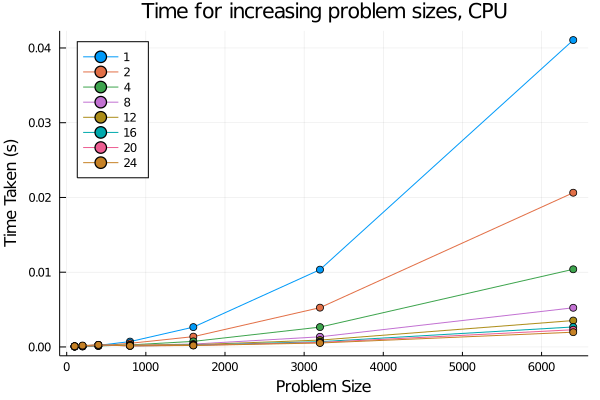

In [15]:
#Plot Prob Size vs Total Time taken
pc1 = plot(Ns_cpu, 
    Ts_cpu, 
    label=num_threads, 
    marker=:circle,
    legend=:topleft,
    title="Time for increasing problem sizes, CPU")
xlabel!("Problem Size")
ylabel!("Time Taken (s)")
#plot(pc1)


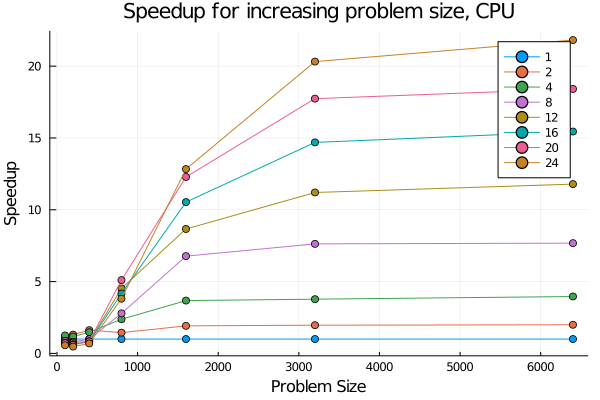

In [35]:
#Plot Prob Size vs Speed up
pc2 = plot(Ns_cpu, 
    speed_up_cpu, 
    label=num_threads,
    marker=:circle,
    title="Speedup for increasing problem size, CPU")
xlabel!("Problem Size")
ylabel!("Speedup")
hline!([2,4,8,12,16,20,24])
#plot(pc2)

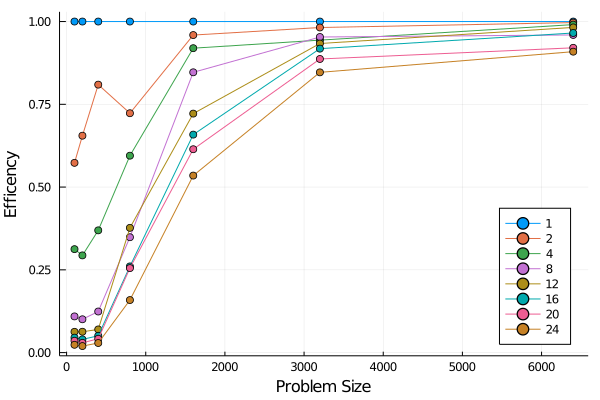

In [36]:
#Plot Prob Size vs Efficency
pc3 = plot(Ns_cpu, eff_cpu, label=num_threads, marker=:circle, legend=:bottomright)
xlabel!("Problem Size")
ylabel!("Efficency")
#plot(pc3)

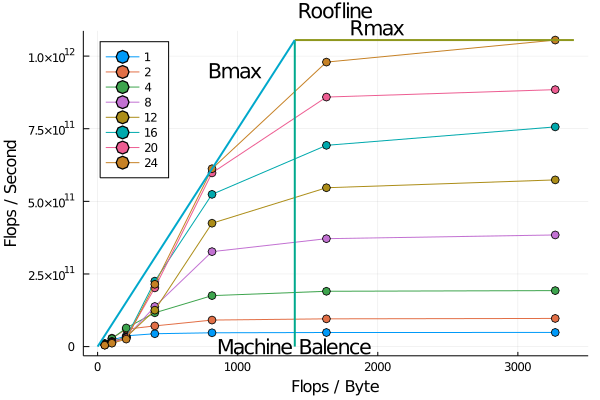

In [118]:
#Calculate B_max and R_max

function roofline_diagram(Ns, Ps, Ts, label)
    add_flops = 49 # Number of flops in the acceleration add function
    mem_moved = 96 # Number of bytes moved to calculate the force on 1 particle to another

    avail_parr = add_flops / mem_moved .* Ns #From class

    r = (add_flops * Ns.^2) ./ Ts #Flops per second for each problem size
    bandwidth = (mem_moved * Ns) ./ Ts

    rmax = maximum(r[:,end])
    bmax = maximum(bandwidth[:,end])
   
    arithmetic_intesity = r ./ bandwidth

    machine_balence =rmax ./ bmax

    pl = plot(arithmetic_intesity, r, marker=:o,
        legend=:topleft,
        label=label) #Arithmetic intensity of each problem 
    plot!([machine_balence, machine_balence], [0, rmax], 
        label="", linewidth=:2,
        annotate=[(machine_balence, 0, "Machine Balence")])
    plot!([machine_balence, 3400], [rmax, rmax], linewidth=:2,
    label="",
    annotate=[(2000, (1.04*rmax), "Rmax")])
    plot!([0,machine_balence], [0, rmax],
    linewidth=:2, 
    label ="",
    annotate=[(0.7 * machine_balence, 0.9 * rmax, "Bmax")])
    plot!()
    xlabel!("Flops / Byte")
    ylabel!("Flops / Second")
    title!("Roofline")
    return pl
end

roofline_diagram(Ns_cpu, Ps_cpu, Ts_cpu, ["1" "2" "4" "8" "12" "16" "20" "24"])


In [37]:
savefig(pc1, dirC * "ParticlesVsTime")
savefig(pc2, dirC *  "ParticlesVsSpeedUp")
savefig(pc3, dirC * "ParticlesVsEfficency")

### Part 3: GPU parallelism (10 points correctness, 5 points performance)

Modify `acceleration!` and `simulate!` to use _GPU parallelism_ on one GPU, an NVidia V100.  Julia has an implemntation of the `CUDA` language for writing kernels and launching them on the GPU.  Your kernels should use the requested number of threads `nthreads`.

Suggestions:


- You should write a kernel for `acceleration_gpu!` using the single instruction, multiple threads (SIMT) paradigm.  I recommend using the "grid stride" construct to help you map the thread to iterations based on their ids.

- Launch a kernel with `NB` blocks of threads, each with `NT` threads using
```julia
@cuda blocks=NB threads=NT kernel(...)
```
You should have `NB * NT == nthreads`.  I recommend choosing block sizes `NB` in multiples of 32, which is the size of a "warp" of threads on an NVidia GPU.

- Broadcasts like `A .= B .+ C` are automatically parallelized if `A`, `B`, and `C` are `CuArray`s.

In [8]:
@inline function acceleration_add_gpu(x::CuDeviceArray{Float64,1},
                          y::CuDeviceArray{Float64,1},
                          v::CuDeviceArray{Float64,1},
                          w::CuDeviceArray{Float64,1})::CuDeviceArray{Float64,1} 
        T = float64
        d = x .- y
        e = v.- w
        r2 = dot(d,d) + T(0.01)
        scale = T(0.05) / r2
        a = d .+ d
        a = a .- e.*scale
        scale = T(0.1)
        a = a .+ e.*scale
    return a
end

function acceleration_gpu!(n::Int64, x::CuDeviceArray{Float64,2,1}, v::CuDeviceArray{Float64,2,1}, a::CuDeviceArray{Float64,2,1})
    t = threadIdx().x
    d = blockDim().x
    b = blockIdx().x
    g = gridDim().x
    id = (b - 1) * d + t
    grid_stride = g * d #number of threads in the grid. So if each thread is 
    #working on its "first" particle, then the next particle it should work on
    #would be for the grid size
    scale = 1 / n
    T = Float64
    
    for i = id:grid_stride:n
      @inbounds xi = (x[i,1], x[i,2], x[i,3], x[i,4])
      @inbounds vi = (v[i,1], v[i,2], v[i,3], v[i,4])
            ai = (zero(T), zero(T), zero(T), zero(T))
            for j = 1:n
                @inbounds xj = (x[j,1], x[j,2], x[j,3], x[j,4])
                @inbounds vj = (v[j,1], v[j,2], v[j,3], v[j,4])
                ai = acceleration_add(xi, xj, vi, vj, ai)
            end
        @inbounds a[i,1:4] .= scale .* ai .+ 0.1 .* xi
    end       
end

@inline function update_particle_gpu!(x::CuDeviceArray{Float64,2,1}, v::CuDeviceArray{Float64,2,1}, a::CuDeviceArray{Float64,2,1}, dt::Float64)
        v .-= dt .* a
        x .+= dt .* v
end

function simulate_gpu!(x::CuMatrix{Float64}, v::CuMatrix{Float64}, timesteps;
                       animate_interval=1, anim=nothing, nthreads=size(x,1))
    n = size(x,1)
    @assert size(x,2) == 4
    @assert size(v) == size(x)
    a = similar(x)
    if anim != nothing
        plot_particles(x)
        frame(anim)
    end
    dt = 0.05
    # you probably want to set up your block size and threads per block here
    # your code here
    NT = 32
    NB = div(nthreads, NT)
     
  #   println("NB: $NB, NT: $NT")
   # @assert NT * NB == nthreads
    #@assert NT % 32 == 0
    for t = 1:timesteps
        # your code here
        @cuda blocks=NB threads=NT acceleration_gpu!(n, x, v, a)
         v .-= dt .* a
         x .+= dt .* v
        #This might be able to be thrown into a gpu function as well
       # @cuda blocks=NB threads=NT  update_particle_gpu!(x,v,a, dt)
        if anim != nothing && t % animate_interval == 0
            xh = Matrix{Float64}(x)
            plot_particles(xh)
            frame(anim)
        end
    end
    if anim != nothing
        return anim
    else
        return nothing
    end
end

simulate_gpu! (generic function with 1 method)

As before, your parallel GPU simulation must match the serial simulation:

In [9]:
n = 96
steps = 7
X = rand(n, 4)
V = rand(n, 4)
Xd = CuMatrix{Float64}(X)
Vd = CuMatrix{Float64}(V)
simulate!(X, V, steps)
simulate_gpu!(Xd, Vd, steps)
Xh = Matrix{Float64}(Xd)
Vh = Matrix{Float64}(Vd)
@assert norm(Xh - X) <= 1.e-7
@assert norm(Vh - V) <= 1.e-7

Kernels on the GPU run _asynchronously_ from the host thread that calls them, so if we want to time their performance we must make sure to synchronize the two devices:

In [10]:
function simulate_gpu_sync!(x::CuMatrix{Float64}, v::CuMatrix{Float64}, timesteps;
                       animate_interval=1, anim=nothing, nthreads=size(x,1))
    CUDA.@sync blocking=false begin
        simulate_gpu!(x, v, timesteps; nthreads=nthreads)
    end
end

simulate_gpu_sync! (generic function with 1 method)

Once you are happy with your implementation, run this cell to collect `Ns_gpu` (a collection of problem sizes), `Ps_gpu` (a collection of thread counts), and `Ts_gpu`, which measures the walltime per timestep for each `n, p` in `Ns_gpu, Ps_gpu`.

In [11]:
Ns_gpu = [100 * 2^k for k = 0:6]

Ps_gpu = [1, 160, 320, 640, 1280, 2560, 5120]
Ts_gpu = Array{Float64,2}(undef, length(Ns_gpu), length(Ps_gpu))

for i = 1:length(Ns_gpu)
    n = Ns_gpu[i]
    X = rand(n,4)
    V = rand(n,4)
    for j = 1:length(Ps_gpu)
        p = Ps_gpu[j]
        println("Starting: n = $n, p = $p ... ")
        if p == 1
            Xcopy = copy(X)
            Vcopy = copy(V)
            t = @belapsed simulate!($X, $Vcopy, 10)
        else
            Xd = CuMatrix{Float64}(X)
            Vd = CuMatrix{Float64}(V)
            t = @belapsed simulate_gpu_sync!($Xd, $Vd, 10; nthreads=$p)
        end
        println("          ... $t seconds")
        Ts_gpu[i,j] = t / 10.
    end
end

Starting: n = 100, p = 1 ... 
          ... 0.000144793 seconds
Starting: n = 100, p = 160 ... 
          ... 0.000292577 seconds
Starting: n = 100, p = 320 ... 
          ... 0.000286103 seconds
Starting: n = 100, p = 640 ... 
          ... 0.000272901 seconds
Starting: n = 100, p = 1280 ... 
          ... 0.000272608 seconds
Starting: n = 100, p = 2560 ... 
          ... 0.000273736 seconds
Starting: n = 100, p = 5120 ... 
          ... 0.000273389 seconds
Starting: n = 200, p = 1 ... 
          ... 0.00043051 seconds
Starting: n = 200, p = 160 ... 
          ... 0.000885447 seconds
Starting: n = 200, p = 320 ... 
          ... 0.000516665 seconds
Starting: n = 200, p = 640 ... 
          ... 0.000496998 seconds
Starting: n = 200, p = 1280 ... 
          ... 0.00054853 seconds
Starting: n = 200, p = 2560 ... 
          ... 0.000549106 seconds
Starting: n = 200, p = 5120 ... 
          ... 0.00054823 seconds
Starting: n = 400, p = 1 ... 
          ... 0.001607417 seconds
Starting: n =

### Part 4: present your results (5 points)

Now that you have collected your measurements of your GPU code, discuss the results.  You should try to communicate the performance results as effectively in words and with figures just as you did for the shared memory CPU code.

The runtime of the GPU code for the same problem sizes is similar to the CPU with several clear distinctions. In the runtime graph, the Serial case had a faster runtime than the 160 threads case. This indicates that the amount of memory movement required for the 160 thread case overshadows the parallelism gain from using multiple blocks of threads. As a general trend, the runtime for low problem sizes (below 1000 particles) is nearly identical between the various threadcounts and serial as the problem isn't large enough to take advantage of the embarrasingly parallel nature of GPUs (not getting near RPeak). 

![](./images/GPU/Runtime_GPU.png)

This trend can also be visualized with the speedup graph where for problem sizes of 100, 200, and 400, there is actually a slowdown for using greater than a serial threadcount. However, each thread size has a separate maximum speedup that corresponds to different problem sizes, where the largest thread count (5120 threads) displays the largest speedup at around 15x the serial case. The maximizaition of speedup for each thread size indicates the problem size at which the the maximum nubmer of $\frac{flops}{second}$ or $R_{Peak}$ is limiting any more gain in performance.

![](./images/GPU/Speedup_GPU.png)

The efficiency graph for GPU is plotted in log scale to display the serveral order of magnitude gain in efficiency over the shared memory case. All threads counts greater than 1 converge in the $\frac{1}{10^{-3}}$ range emphasizing that the individual thread capability is being maximized with respect to the problem size. In addition, when the number of threads per block was increased to reduce the number of blocks, an insignificant change in efficiency and speedup were noticed indicating that performance losses to overhead of assigning a few more blocks to perform computations is small.

![](./images/GPU/Efficiency_GPU.png)

In [8]:
num_threads = [1 160 320 640 1280 2560 5120]
num_particles = [100 200 400 800 1600 3200 6400]
Ts_serial = Ts_gpu[:,1]

dirG = "./images/GPU/"

#Plot Prob Size vs Total Time taken
pg1 = plot(Ns_gpu, 
    Ts_gpu, 
    label=num_threads, 
    marker=:circle,
    legend=:topleft,
    title="Time for increasing problem sizes, GPU")
xlabel!("Problem Size")
ylabel!("Time Taken (s)")
# plot(pg1)

LoadError: UndefVarError: Ts_gpu not defined

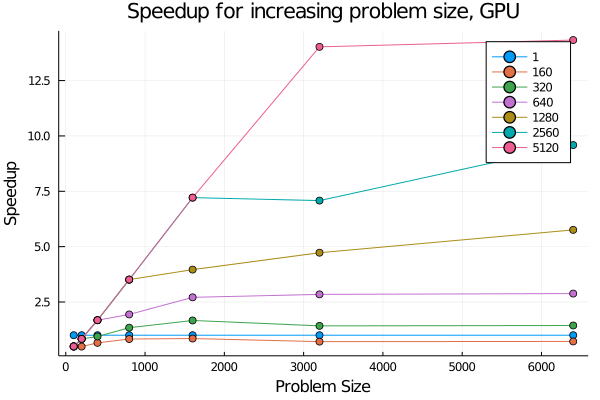

In [100]:
#Plot Prob Size vs Speed up
pg2 = plot(Ns_gpu, 
    Ts_serial ./ Ts_gpu, 
    label=num_threads,
    marker=:circle,
    title="Speedup for increasing problem size, GPU")
xlabel!("Problem Size")
ylabel!("Speedup")
# plot(pg2)

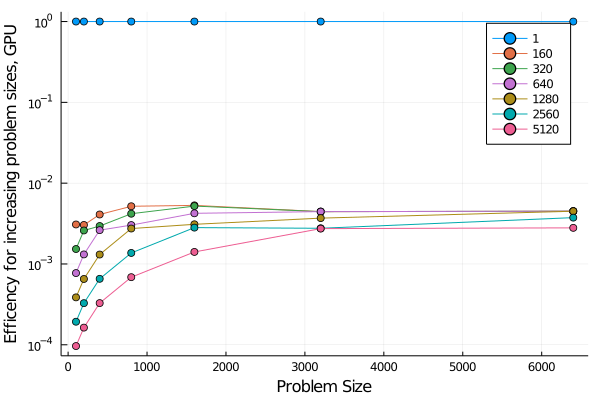

In [101]:
#Plot Prob Size vs Efficency


pg3 = plot(Ns_gpu, (Ts_serial ./ Ts_gpu) ./ Ps_gpu', 
    label=num_threads, marker=:circle, 
    legend=:topright, yaxis=:log)



xlabel!("Problem Size")
ylabel!("Efficency for increasing problem sizes, GPU")
# plot(pg3)

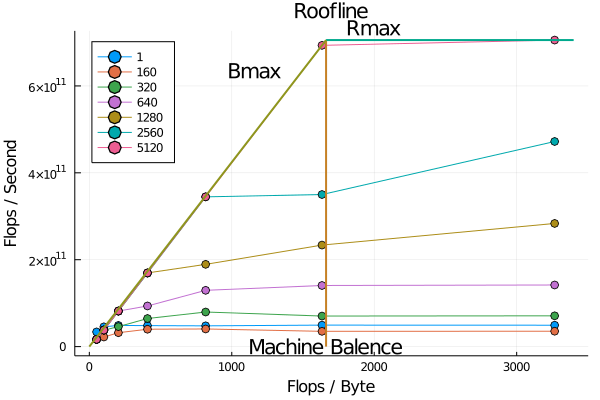

In [119]:
pg4 = roofline_diagram(Ns_gpu, Ps_gpu, Ts_gpu, [1 160 320 640 1280 2560 5120])


In [5]:
dirG = "./images/GPU/"
savefig(pg1, dirG * "ParticlesVsTime")
savefig(pg2, dirG *  "ParticlesVsSpeedUp")
savefig(pg3, dirG * "ParticlesVsEfficency")
savefig(pg4, dirG * "Roofline")

LoadError: UndefVarError: savefig not defined

### Part 5: intercomparison (5 points)

Now that we have measurements on two different types of devices (`Ts_cpu` and `Ts_gpu`), how can we compare them?  Use plots and text to compare both the absolute performance and relative efficiency of the CPUs and the GPU on different problem sizes.  One problem you will have to answer: a GPU thread is not directly comparable to a CPU thread, so how should  we talk about the efficiencies of these two devices.

One possible framing for your comparison: you are trying to decide whether to buy cloud time on nodes that either have CPUs like the ones you are using and no GPU, or vice versa.  Would your answer depend on:

- The number of particles in a simulation?
- The number of timesteps in a simulation?
- The number of concurrent simulations you want to run?

As a general overview, the CPUs have limited number of cores with a higher processing rate whereas GPU has large number of cores each with low processing rate. GPU focused on solving very large problems that, when separated, are computationally not intensive whereas CPU is designed for smaller problems where each iteration contains a higher workload.

Absolute performance of both CPU and GPU is evaluated through a direct runtime comparison for all problem sizes across corresponding thread ratios. The graph below displays the ratio of runetimes for Gpu vs Cpu for corresponding thread sizes where the highest Gpu thread is compared against the two largest CPU threads and the dashed horizontal line indicats the threshold at which computational time is identical for both. For small problem sizes below 1000 particles, the GPU runs faster than the CPU since the CPU has few cores in comparison to the GPU which has a much higher available parallelism. However, as the problem size and the number of CPU cores increases it gains a runtime advantage over the GPU as the CPU's maximum flop rate is larger than that of the GPU . Furthermore, it is possible that the problem sizes were not large enough to fully utilize the maximum number of threads per block which may cause an increase of GPU runtime over the CPU at higher larger problem sizes.

![](./images/Runtime_Ratio.png)

We can also use the CPU and GPU roofline diagrams to compare both devices. 

![](./images/CPU/Roofline_CPU.png) ![](./images/GPU/Roofline_GPU.png)

$R_{max}$ is the empiricaly measured maximum flop rate for each device. Thread-level parallelism provides a maximum flop rate of about $1.1\times10^{12}$ Flops/second, which is approximalty 1.5 times larger than the maximum flop rate of the GPU of $0.7\times10^{12}$ Flops/second. We can also see that the GPU's performance was limited frequently by the bandwidth of the machine. 


If we were deciding on using CPUs or GPUs, we would hvae to take into account the number of particles, timesteps and simulations. Even though the CPU has a higher maximum flop rate, we are limited by the numer of CPUs availibe to us. For problems with larger numbers of particles, or if we wanted to run multiple concurrent simulations, it would probably be best to utilize the GPUs parallelism instead of relying of having multiple CPUs. However, in cases where we are calculating a larger number of timesteps for the simulation, utilizing the CPU's speed and low overhead compared to the GPU might be benefical considering that that portion of the problem can not by parallelized. 